In [2]:

from extract_segId_from_prediction import graph_with_segId_prediction
from evaluation_matrix import splits_error,merge_error,rand_voi_split_merge
import matplotlib.pyplot as plt
import os
import re
import daisy
from daisy import Coordinate

In [71]:

def to_pixel_coord_xyz(zyx):
    zyx = (daisy.Coordinate(zyx) / daisy.Coordinate((40, 4, 4)))
    return daisy.Coordinate((zyx[2], zyx[1], zyx[0]))


def get_error_dict(skeleton_path,seg_path,threshold_list):
    #skeleton_path = '/n/groups/htem/temcagt/datasets/cb2/segmentation/python_scripts/yh231/cb2_cutout4.csv'
    # segment_ds = daisy.open_ds(
    #         "/home/yh231/segmentation/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr",
    #         "volumes/segmentation_0.500")
    #parent_path = '/home/yh231/segmentation/cb2_segmentation/outputs/2019_03/pl2_yumin/cb2_v2/100000/output.zarr'
    # parent_path = '/home/yh231/segmentation/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr'
    # files = [f for f in os.listdir(parent_path+'/volumes') if re.match(r'segmentation.*',f)]

    # #files = ['segmentation_0.500']
    # files.sort()
    numb_split = []
    numb_merge = []
    split_error_dict = {}
    merge_error_dict = {}
    for file in threshold_list:
        graph = graph_with_segId_prediction(skeleton_path,seg_path,'volumes/'+ file) # graph 
        split_error_num, split_list = splits_error(graph)
        numb_split.append(split_error_num)
        split_error_dict[file]=split_list ##dict == {segmentation_threshold:{sk_id:(((zyx),(zyx)),....),...} }   
        merge_error_num, merge_list = merge_error(graph)
        numb_merge.append(int(merge_error_num))
        merge_error_dict[file]=merge_list ##dict == {segmentation_threshold:{seg_id:([{(zyx),(zyx)},sk1,sk2],....),...} } 
    return numb_split,numb_merge,split_error_dict,merge_error_dict
def get_rand_voi(skeleton_path,seg_path,threshold_list):
    rand_split_list, rand_merge_list, voi_split_list, voi_merge_list = [], [], [], []
    for file in threshold_list:
        graph = graph_with_segId_prediction(skeleton_path,seg_path,'volumes/'+ file)
        rand_split, rand_merge, voi_split, voi_merge = rand_voi_split_merge(graph)
        rand_split_list.append(rand_split)
        rand_merge_list.append(rand_merge)
        voi_split_list.append(voi_split)
        voi_merge_list.append(voi_merge)
    return rand_split_list, rand_merge_list, voi_split_list, voi_merge_list

def compare_split_merge(threshold_list, numb_split,numb_merge):
    
    plt.subplot(211)
    plt.plot(list(map(lambda x: x.replace("segmentation_",""),threshold_list)),numb_merge,color = 'b')
    plt.ylabel('merge error')
    plt.subplot(212)
    plt.plot(list(map(lambda x: x.replace("segmentation_",""),threshold_list)),numb_split,color = 'r')
    plt.ylabel('split error')
    plt.savefig('cutouts5.png')

##compare with lines with any model and cutouts
def compare_threshold(threshold_list,filename,chosen_matrice,markers,colors,*split_and_merge):#split_and_merge should be modelname,merge,split

    fig, ax = plt.subplots(figsize=(8, 6))
    #print(len(split_and_merge))
    for j in range(int(len(split_and_merge)/3)): # zorder; to make points(markers) over the line
        ax.plot(split_and_merge[j*3+1],split_and_merge[j*3+2],label = split_and_merge[j*3],color = colors[j],zorder = 1,alpha=0.5,linewidth=2.5)
        for a,b,m,l in zip(split_and_merge[j*3+1],split_and_merge[j*3+2],markers,threshold_list):
            if j == 0:
                ax.scatter(a,b,marker=m,c=colors[j],label=l.replace("segmentation_",""),zorder = 2,alpha=0.5,s=50)
            else:
                ax.scatter(a,b,marker=m,c=colors[j],zorder=2,alpha=0.5,s=50)
        # for i, labels in enumerate(threshold_list): #add annotation to each point on that line if needed 
        #     ax.annotate(labels.replace("segmentation",""),(split_and_merge[j*3+1][i],split_and_merge[j*3+2][i]))
    ax.legend()
    if chosen_matrice == 'number':
        ax.set_ylim(bottom=-0.8)
        ax.set_xlim(left=-0.8)
        plt.xlabel('Merge Error Count')
        plt.ylabel('Split Error Count')
    elif chosen_matrice == 'rand':
        ax.set_ylim(bottom=0)
        ax.set_xlim(left=-0.01)
        plt.xlabel('Merge Rand')
        plt.ylabel('Split Rand')
    elif chosen_matrice == 'voi':
        ax.set_ylim(bottom=0)
        ax.set_xlim(left=-0.01)
        plt.xlabel('Merge VOI')
        plt.ylabel('Split VOI')
    plt.savefig(filename+'_'+chosen_matrice, dpi=300)

def compare_threshold_multi_model(
    threshold_list,
    filename,
    skeleton_path,
    chosen_matrices,
    list_seg_path,
    markers = ['.',',','o','v','^','<','>','1','2'],
    colors=['b','g','r','c','m','y','k']):
    works = False
    if 'number' in chosen_matrices:
        split_and_merge_number = []
        for seg_path in list_seg_path: 
            numb_split,numb_merge,_,_ = get_error_dict(skeleton_path,seg_path,threshold_list)
            ###model = 130000 or things like setup01_40000
            if re.search(r"setup[0-9]{2}",seg_path):
                model = re.search(r"setup[0-9]{2}",seg_path).group(0)+"_"+re.search(r"[0-9]+000",seg_path).group(0)
            else:
                model = "cb2_130000"
            split_and_merge_number.extend((model,numb_merge,numb_split))
        #compare_threshold(threshold_list,filename,'number',markers,colors,*split_and_merge)
        works = True
    if 'rand' in chosen_matrices:
        split_and_merge_rand = []
        for seg_path in list_seg_path:
            rand_split_list, rand_merge_list,_,_ = get_rand_voi(skeleton_path,seg_path,threshold_list)
            if re.search(r"setup[0-9]{2}",seg_path):
                model = re.search(r"setup[0-9]{2}",seg_path).group(0)+"_"+re.search(r"[0-9]+000",seg_path).group(0)
            else:
                model = "cb2_130000"
            split_and_merge_rand.extend((model,rand_merge_list,rand_split_list))
        #compare_threshold(threshold_list,filename,'rand',markers,colors,*split_and_merge_rand)
        works = True
    if 'voi' in chosen_matrices:
        split_and_merge_voi = []
        for seg_path in list_seg_path:
            _,_, voi_split_list, voi_merge_list = get_rand_voi(skeleton_path,seg_path,threshold_list)
            if re.search(r"setup[0-9]{2}",seg_path):
                model = re.search(r"setup[0-9]{2}",seg_path).group(0)+"_"+re.search(r"[0-9]+000",seg_path).group(0)
            else:
                model = "cb2_130000"
            split_and_merge_voi.extend((model,voi_merge_list,voi_split_list))            
        #compare_threshold(threshold_list,filename,'voi',markers,colors,*split_and_merge_voi)
        works = True
    if not works:
        print("please provide the correct string for chosen matrices from 'number','rand' or 'voi'") 
    return split_and_merge_number,split_and_merge_rand,split_and_merge_voi


def print_the_split_error(split_error_dict,seg_path,threshold):
    segment_ds = daisy.open_ds(
             seg_path,
             "volumes/"+threshold)
    print (threshold)
    for skel_id in split_error_dict[threshold]:
        print("Skeleton: ", skel_id)
        errors = split_error_dict[threshold][skel_id]
        for error in errors:
            for point in error:
                #print(point)
                print(to_pixel_coord_xyz(point))
                print('segid is: %d'%segment_ds[Coordinate(point)])

    #return merge_error_dict,split_error_dict

def print_the_merge_error(merge_error_dict,threshold):
    print (threshold)
    for seg_id in merge_error_dict[threshold]:
        print("Segmentation:", seg_id)
        errors = merge_error_dict[threshold][seg_id]
        for error in errors:
            print (to_pixel_coord_xyz(error[0][0]))
            print ('sk_id is: %d'%error[1])
            print (to_pixel_coord_xyz(error[0][1]))
            print ('sk_id is: %d'%error[2])

In [7]:
#tset code for rand and voi
skeleton_path = '/n/groups/htem/temcagt/datasets/cb2/segmentation/python_scripts/yh231/cb2_cutout4.csv'
seg_path ='/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr'
graph = graph_with_segId_prediction(skeleton_path,seg_path,'volumes/segmentation_0.300' )
data = rand_voi_split_merge(graph)
print (data)

/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr
volumes/segmentation_0.300
(0.17980817140009964, 0.0, 0.490296647368174, 0.0)


In [ ]:
## create the graph of comparing different model 
threshold_list = ['segmentation_0.100','segmentation_0.200','segmentation_0.300','segmentation_0.400','segmentation_0.500','segmentation_0.600','segmentation_0.700','segmentation_0.800','segmentation_0.900']
skeleton_path= '/n/groups/htem/temcagt/datasets/cb2/segmentation/python_scripts/yh231/cb2_cutout4.csv'


seg_path_130k ='/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr'

seg_path_40k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup00/40000/output.zarr'
seg_path_60k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup00/60000/output.zarr'
seg_path_80k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup00/80000/output.zarr'
seg_path_140k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup01/140000/output.zarr'
seg_path_160k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup01/160000/output.zarr'
seg_path_180k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup01/180000/output.zarr'
number, rand ,voi = compare_threshold_multi_model(threshold_list,'eval01',skeleton_path,['rand','voi','number'],[seg_path_40k,seg_path_60k,seg_path_80k,seg_path_130k,seg_path_140k,seg_path_160k,seg_path_180k])


/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup00/40000/output.zarr
volumes/segmentation_0.100
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup00/40000/output.zarr
volumes/segmentation_0.200


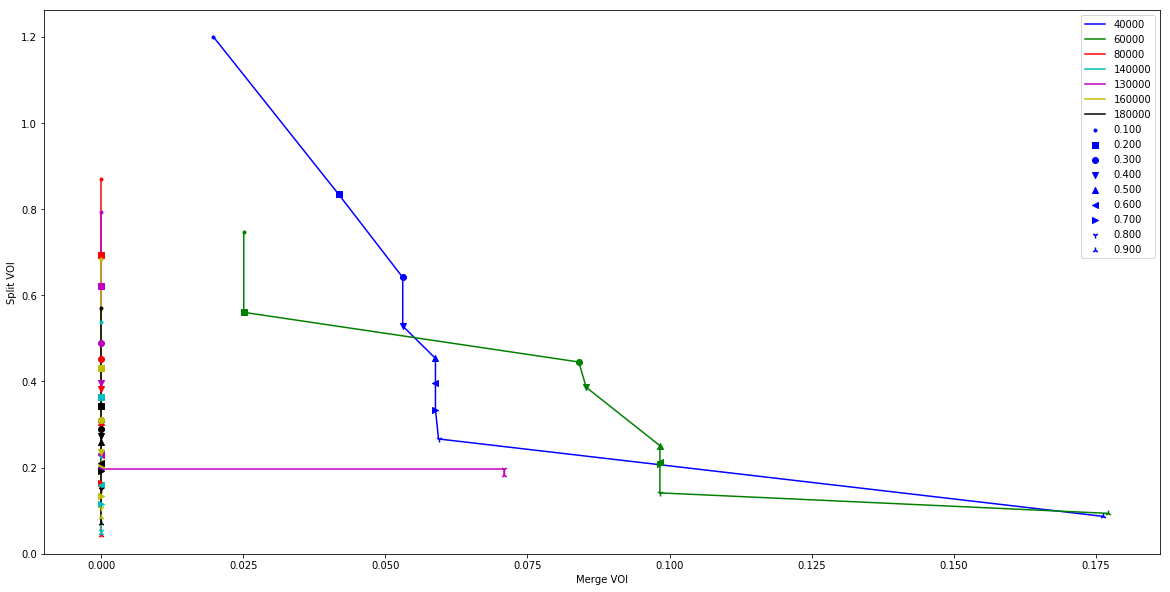

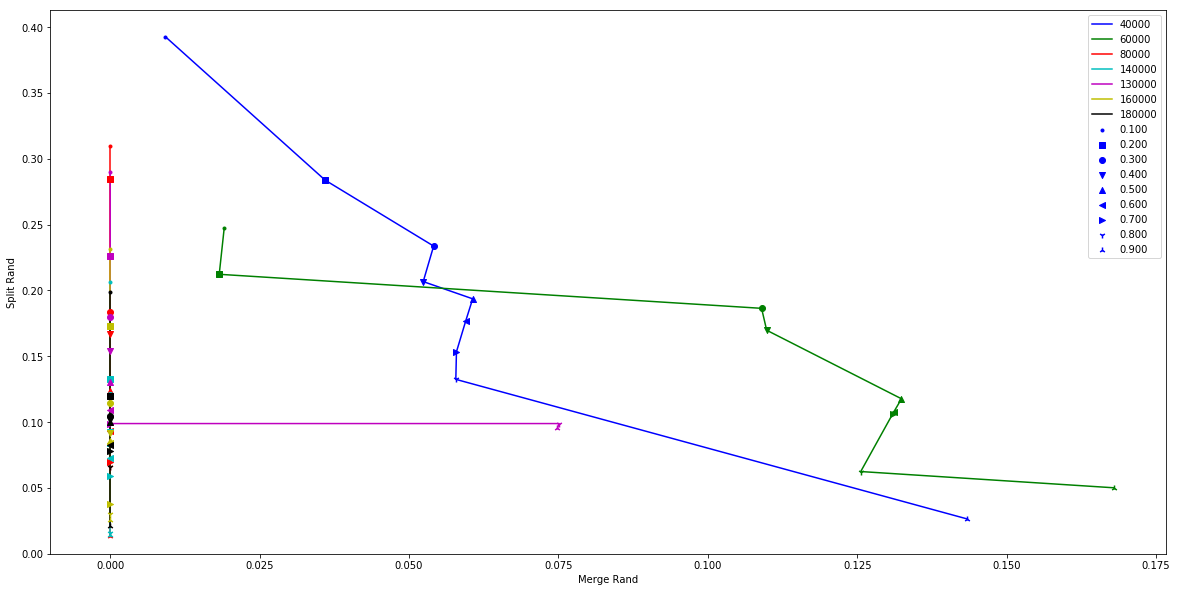

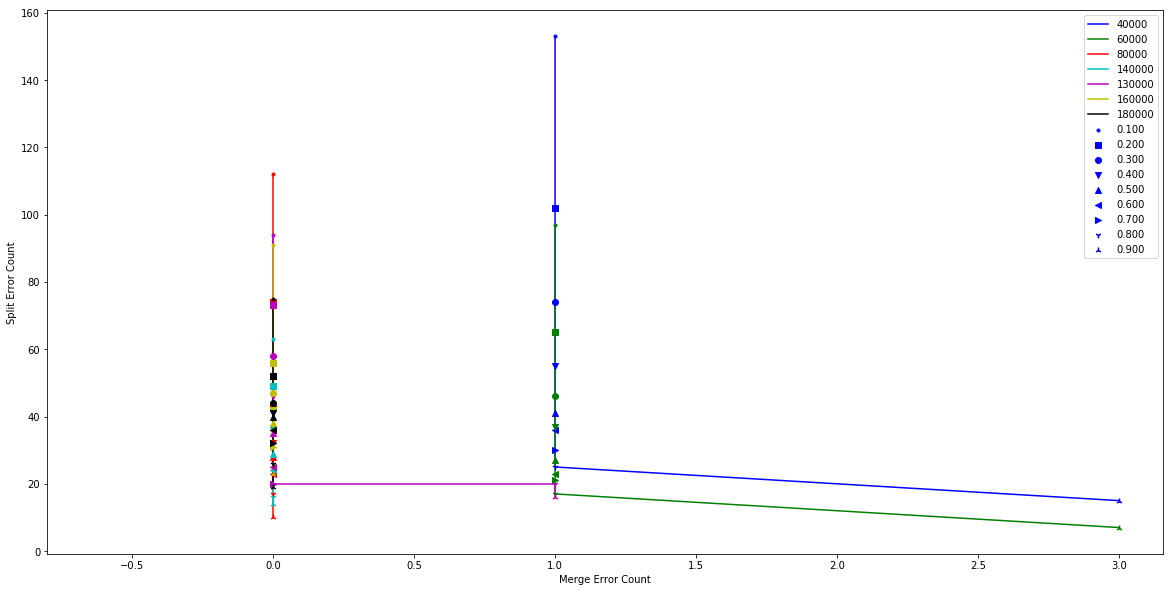

In [46]:
markers = ['o','','^','','s','','p','','D']
colors=['b','g','r','c','m','y','k']
compare_threshold(threshold_list,'eval01','voi',markers,colors,*voi)
compare_threshold(threshold_list,'eval01','rand',markers,colors,*rand)
compare_threshold(threshold_list,'eval01','number',markers,colors,*number)

In [72]:
seg_path_130k ='/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr'
seg_path_40k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/40000/output.zarr'
seg_path_60k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/60000/output.zarr'
seg_path_80k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/80000/output.zarr'
seg_path_140k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/140000/output.zarr'
seg_path_160k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/160000/output.zarr'
seg_path_180k = '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/180000/output.zarr'
number3, rand3 ,voi3 = compare_threshold_multi_model(threshold_list,'eval03',skeleton_path,['rand','voi','number'],[seg_path_40k,seg_path_60k,seg_path_80k,seg_path_130k,seg_path_140k,seg_path_160k,seg_path_180k])


/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/40000/output.zarr
volumes/segmentation_0.100
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/40000/output.zarr
volumes/segmentation_0.200
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/40000/output.zarr
volumes/segmentation_0.300
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/40000/output.zarr
volumes/segmentation_0.400
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/40000/output.zarr
volumes/segmentation_0.500
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup04/40000/output.zarr
volumes/segmentation_0.600
/n/groups/htem/temcagt/datasets/cb2/segmentati

/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/160000/output.zarr
volumes/segmentation_0.800
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/160000/output.zarr
volumes/segmentation_0.900
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/180000/output.zarr
volumes/segmentation_0.100
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/180000/output.zarr
volumes/segmentation_0.200
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/180000/output.zarr
volumes/segmentation_0.300
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/180000/output.zarr
volumes/segmentation_0.400
/n/groups/htem/temcagt/datasets/cb2/segm

/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr
volumes/segmentation_0.600
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr
volumes/segmentation_0.700
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr
volumes/segmentation_0.800
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/cb2/130000/output.zarr
volumes/segmentation_0.900
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/160000/output.zarr
volumes/segmentation_0.100
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/160000/output.zarr
volumes/segmentation_0.200
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2

/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/140000/output.zarr
volumes/segmentation_0.400
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/140000/output.zarr
volumes/segmentation_0.500
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/140000/output.zarr
volumes/segmentation_0.600
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/140000/output.zarr
volumes/segmentation_0.700
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/140000/output.zarr
volumes/segmentation_0.800
/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_segmentation/outputs/2019_03/cb2_synapse_cutout4/setup05/140000/output.zarr
volumes/segmentation_0.900
/n/groups/htem/temcagt/datasets/cb2/segm

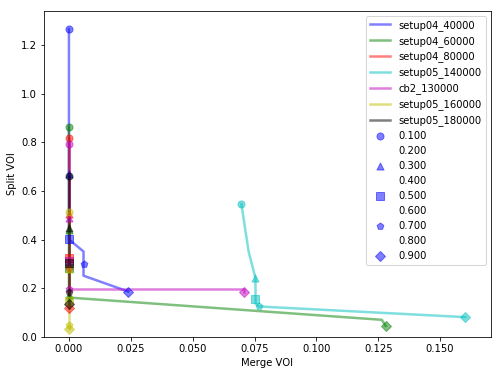

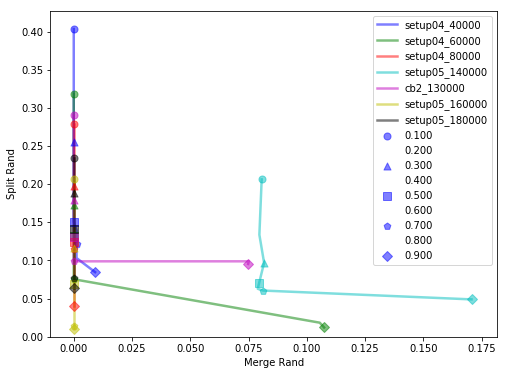

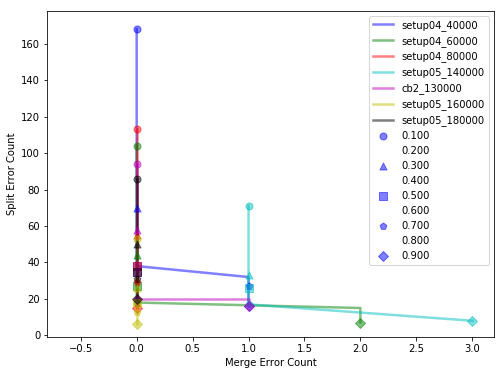

In [73]:
markers = ['o','','^','','s','','p','','D']
compare_threshold(threshold_list,'eval03','voi',markers,colors,*voi3)
compare_threshold(threshold_list,'eval03','rand',markers,colors,*rand3)
compare_threshold(threshold_list,'eval03','number',markers,colors,*number3)